In [25]:
# open pert_level_raw_expression.csv as dataframe 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
random.seed(42)

In [26]:
pert_level_data_raw_exp = pd.read_csv('pert_level_raw_exp_non_adj.csv')
pert_level_data_scf = pd.read_csv('pert_level_scfoundation_non_adj.csv')
pert_level_data_scbert = pd.read_csv('pert_level_scbert_non_adj.csv')
pert_level_data_uce = pd.read_csv('pert_level_uce_non_adj.csv')
pert_level_data_scgpt = pd.read_csv('pert_level_scgpt_non_adj.csv')
pert_level_data_gf = pd.read_csv('pert_level_gf_non_adj.csv')

pert_level_data = pd.concat([pert_level_data_raw_exp, pert_level_data_scbert, pert_level_data_scgpt, pert_level_data_gf, pert_level_data_uce, pert_level_data_scf], axis=0)
pert_level_data

,Name,End Time,Runtime,Tags,test/mse,test/adjusted_mse,de_test/mse,test/num_de_genes,data.eval_pert,data.split,data.fm,model.eval_pert,model.fm,model.mean_adjusted
0,fanciful-haze-3028,2024-08-26T15:22:29.000Z,35,"IKZF3, eval, norman, raw_expression, replicate...",1.395404,NaN,NaN,20.0,IKZF3,0.7,raw_expression,NaN,NaN,${mean_adjusted}
1,azure-fire-3045,2024-08-26T15:23:08.000Z,42,"CEBPE, eval, norman, raw_expression, replicate...",1.179576,NaN,NaN,20.0,CEBPE,0.7,raw_expression,NaN,NaN,${mean_adjusted}
2,solar-leaf-3034,2024-08-26T15:22:55.000Z,43,"CEBPA, eval, norman, raw_expression, replicate...",1.008216,NaN,NaN,20.0,CEBPA,0.7,raw_expression,NaN,NaN,${mean_adjusted}
3,crimson-thunder-3027,2024-08-26T15:22:29.000Z,35,"SLC4A1, eval, norman, raw_expression, replicat...",0.851480,NaN,NaN,20.0,SLC4A1,0.7,raw_expression,NaN,NaN,${mean_adjusted}
4,helpful-glade-3002,2024-08-26T15:19:52.000Z,73,"ETS2, eval, norman, raw_expression, replicate_...",0.543382,NaN,NaN,19.0,ETS2,0.0,raw_expression,NaN,NaN,${mean_adjusted}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,azure-totem-2861,2024-08-24T23:34:47.000Z,93,"CBFA2T3, eval, norman, replicate_0, scfoundati...",0.571170,NaN,NaN,20.0,CBFA2T3,0.0,scfoundation,NaN,NaN,NaN
53,olive-silence-2922,2024-08-24T23:46:31.000Z,35,"SLC4A1, eval, norman, replicate_0, scfoundatio...",0.837039,NaN,NaN,20.0,SLC4A1,0.7,scfoundation,NaN,NaN,NaN
54,summer-bee-2905,2024-08-24T23:44:42.000Z,38,"CEBPA, eval, norman, replicate_0, scfoundation...",1.005020,NaN,NaN,20.0,CEBPA,0.7,scfoundation,NaN,NaN,NaN
55,leafy-night-2925,2024-08-24T23:47:56.000Z,33,"CEBPE, eval, norman, replicate_2, scfoundation...",1.161847,NaN,NaN,20.0,CEBPE,0.7,scfoundation,NaN,NaN,NaN


In [27]:
# split the pert_level_data based on the data.split column into two separate dataframes, one for 0.0 and another for 0.7 
pert_level_data_0 = pert_level_data[pert_level_data['data.split'] == 0.0]
pert_level_data_7 = pert_level_data[pert_level_data['data.split'] == 0.7]
pert_level_data_0_grouped = pert_level_data_0.groupby(['data.eval_pert', 'data.fm'])['test/mse'].mean().reset_index().dropna()
pert_level_data_7_grouped = pert_level_data_7.groupby(['data.eval_pert', 'data.fm'])['test/mse'].mean().reset_index()
pert_level_data_0_grouped

,data.eval_pert,data.fm,test/mse
0,AHR,geneformer,0.289045
1,AHR,raw_expression,0.294854
2,AHR,scbert,0.288498
3,AHR,scfoundation,0.287381
4,AHR,scgpt,0.288892
...,...,...,...
257,ZNF318,raw_expression,0.412802
258,ZNF318,scbert,0.399559
259,ZNF318,scfoundation,0.400662
260,ZNF318,scgpt,0.397787


In [28]:
pivot_0 = pert_level_data_0_grouped.pivot(index="data.eval_pert", columns="data.fm", values="test/mse")
pivot_7 = pert_level_data_7_grouped.pivot(index="data.eval_pert", columns="data.fm", values="test/mse")
pivot_7

data.fm,geneformer,raw_expression,scbert,scfoundation,scgpt,uce
data.eval_pert,,,,,,
AHR,0.517461,0.505265,0.511841,0.526978,0.524230,0.527808
CEBPA,1.009200,1.008216,1.002309,1.005020,1.001701,1.002595
CEBPE,1.085474,1.179576,1.078296,1.161847,1.143108,1.140522
GLB1L2,0.515864,0.521665,0.535944,0.519089,0.519660,0.522053
IKZF3,1.510103,1.395404,1.474665,1.529226,1.529429,1.533526
SLC4A1,0.774525,0.851480,0.794596,0.837039,0.828724,0.834458


In [29]:
# required_perturbations = ['SET', 'SPI1']
# other_perturbations = random.sample(list(pivot_0.index), 4)
# selected_perturbations = required_perturbations + other_perturbations
# pivot_0 = pivot_0.loc[selected_perturbations]

In [30]:
pivot_7

data.fm,geneformer,raw_expression,scbert,scfoundation,scgpt,uce
data.eval_pert,,,,,,
AHR,0.517461,0.505265,0.511841,0.526978,0.524230,0.527808
CEBPA,1.009200,1.008216,1.002309,1.005020,1.001701,1.002595
CEBPE,1.085474,1.179576,1.078296,1.161847,1.143108,1.140522
GLB1L2,0.515864,0.521665,0.535944,0.519089,0.519660,0.522053
IKZF3,1.510103,1.395404,1.474665,1.529226,1.529429,1.533526
SLC4A1,0.774525,0.851480,0.794596,0.837039,0.828724,0.834458


In [31]:
# save pivot_0 and pivot_7 as csv files 
pivot_0.to_csv('pivot_0_non_adj.csv')
pivot_7.to_csv('pivot_7_non_adj.csv')

In [20]:
# pivot_0.loc['Mean'] = pivot_0.mean()
pivot_7.loc['Mean'] = pivot_7.mean()

columns_order = ['raw_expression', 'scbert', 'geneformer', 'scgpt', 'uce', 'scfoundation']
pivot_0 = pivot_0[columns_order]
pivot_7 = pivot_7[columns_order]

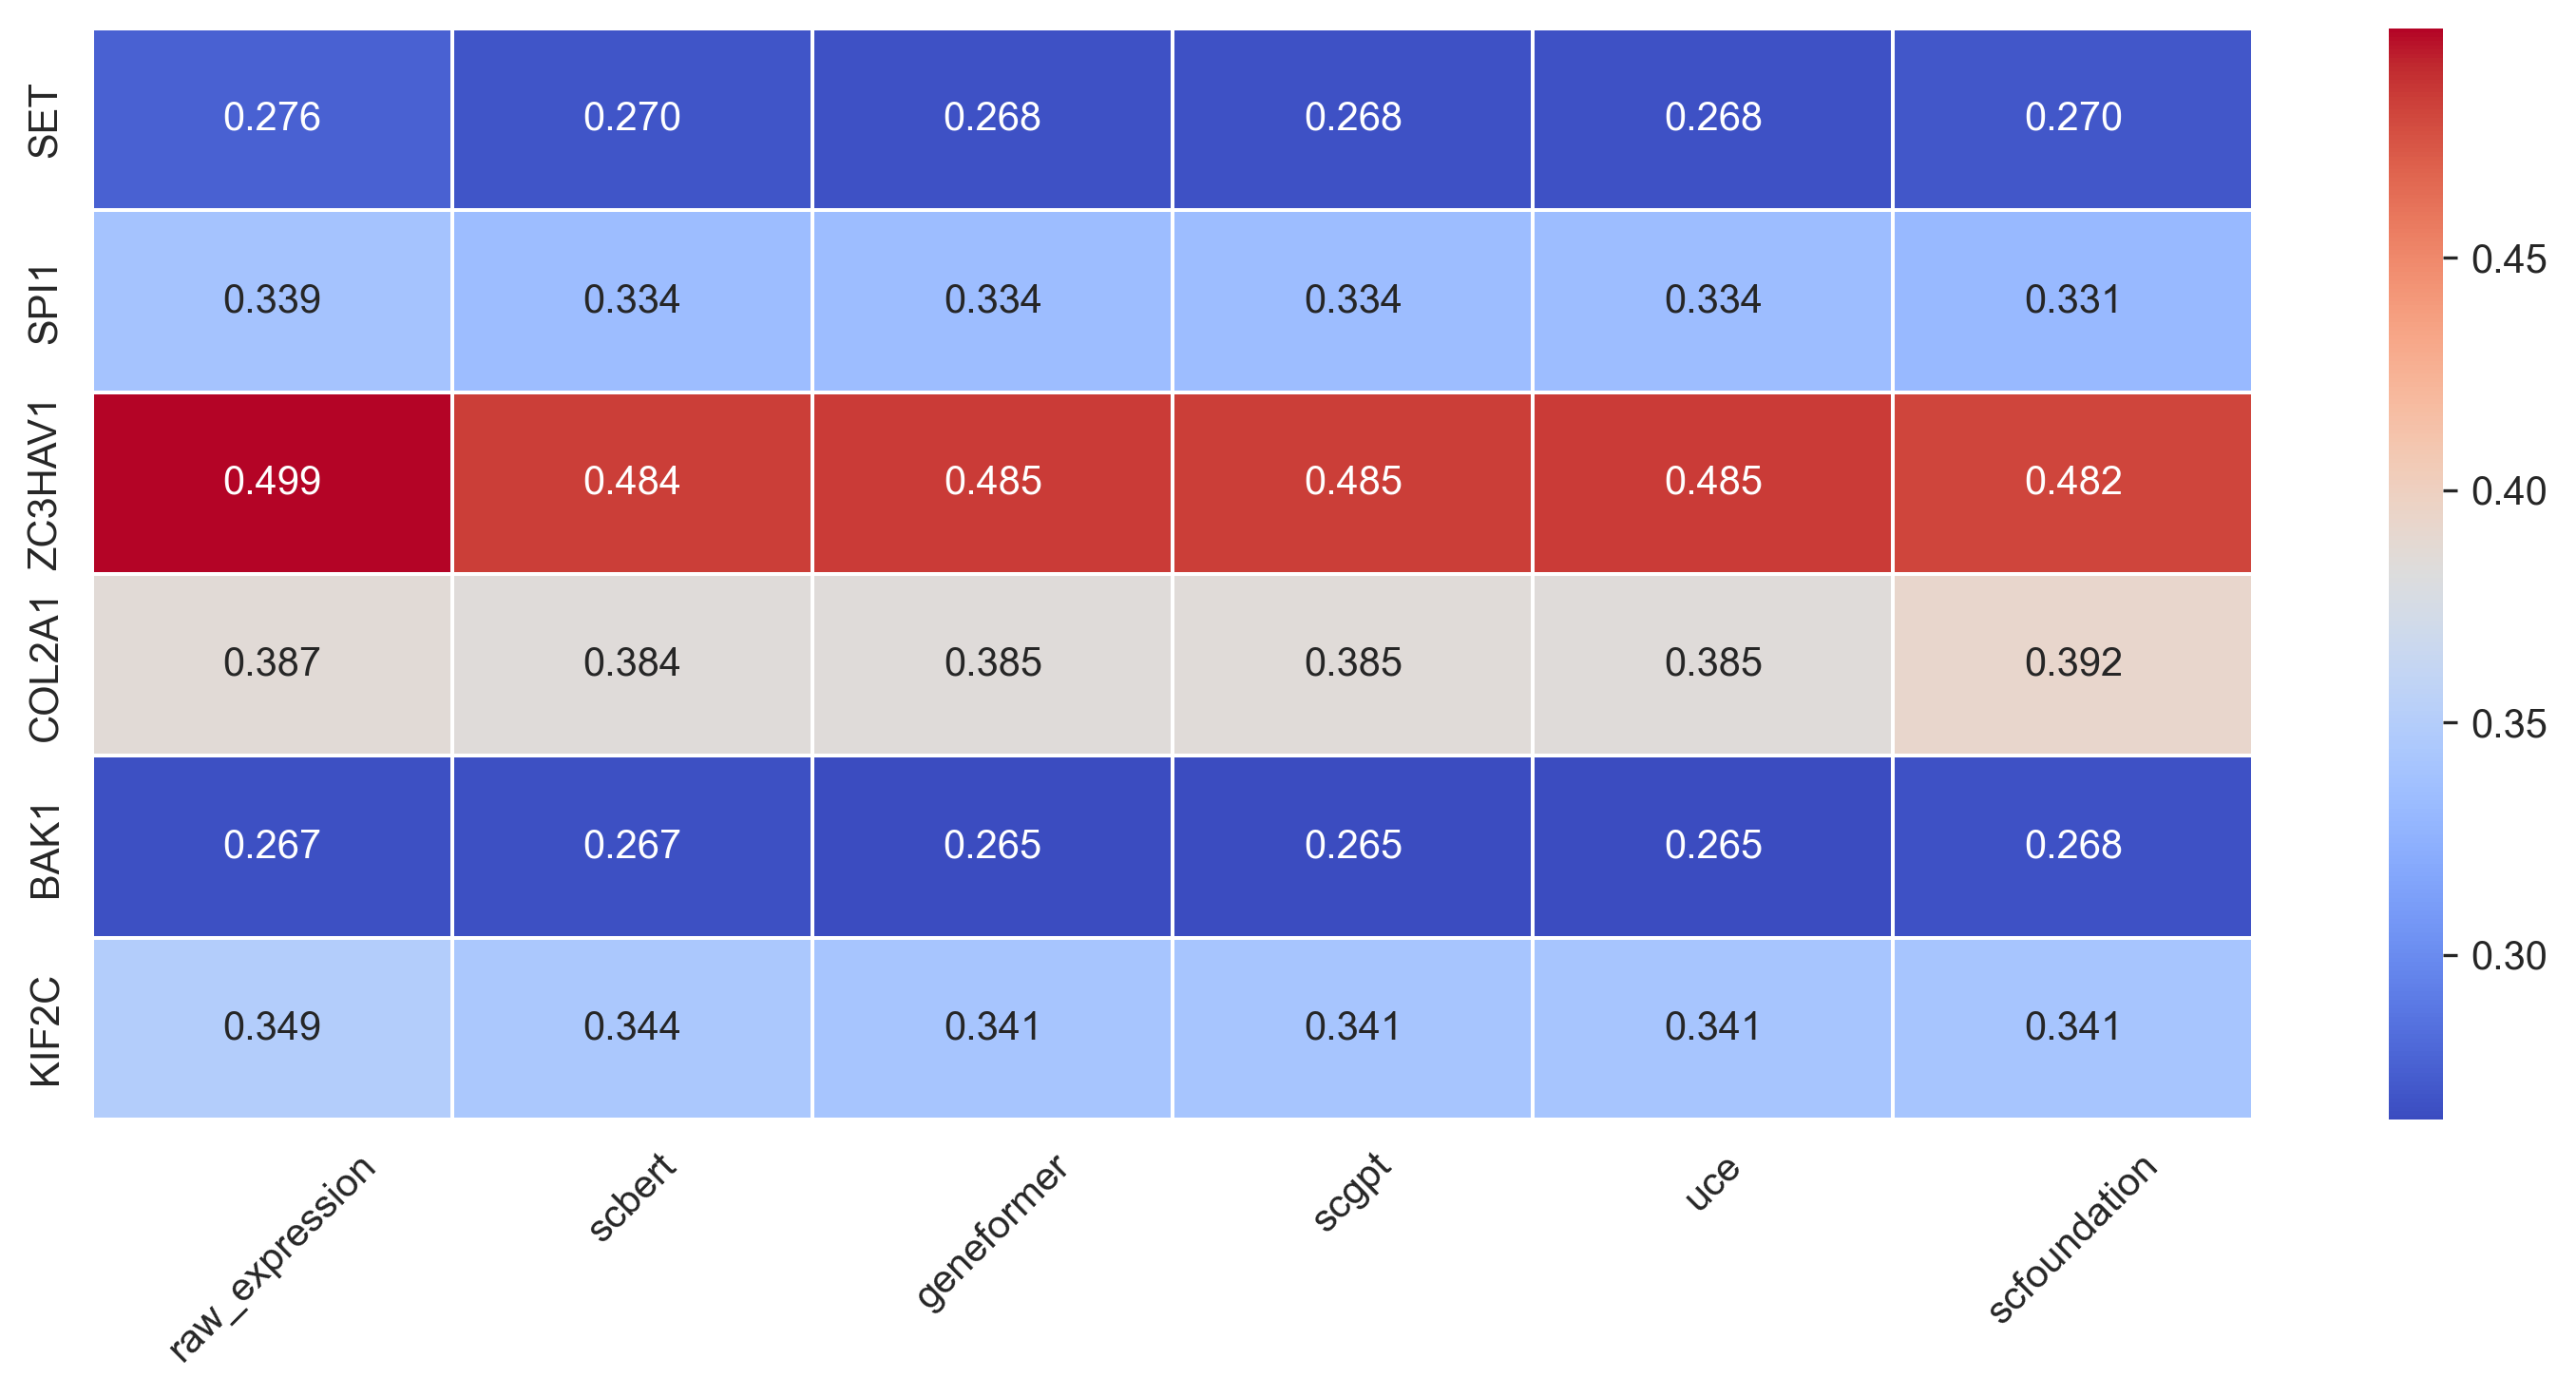

In [24]:
# Plot heatmap for pert_level_data_0
plt.figure(figsize=(10, 5), dpi=300)
sns.heatmap(pivot_0, annot=True, fmt=".3f", linewidths=.5, cmap="coolwarm", cbar=True)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45)
yticks = range(len(pivot_0.index))
plt.xticks(rotation=45)
# plt.gca().set_yticks([y + 0.5 for y in yticks])
# plt.gca().set_yticklabels(pivot_0.index, rotation=90, fontsize=5)
# plt.colorbar()
plt.tight_layout()
# plt.show()
plt.savefig('individual_perturbation_results_heatmap_0_non_adj.pdf')

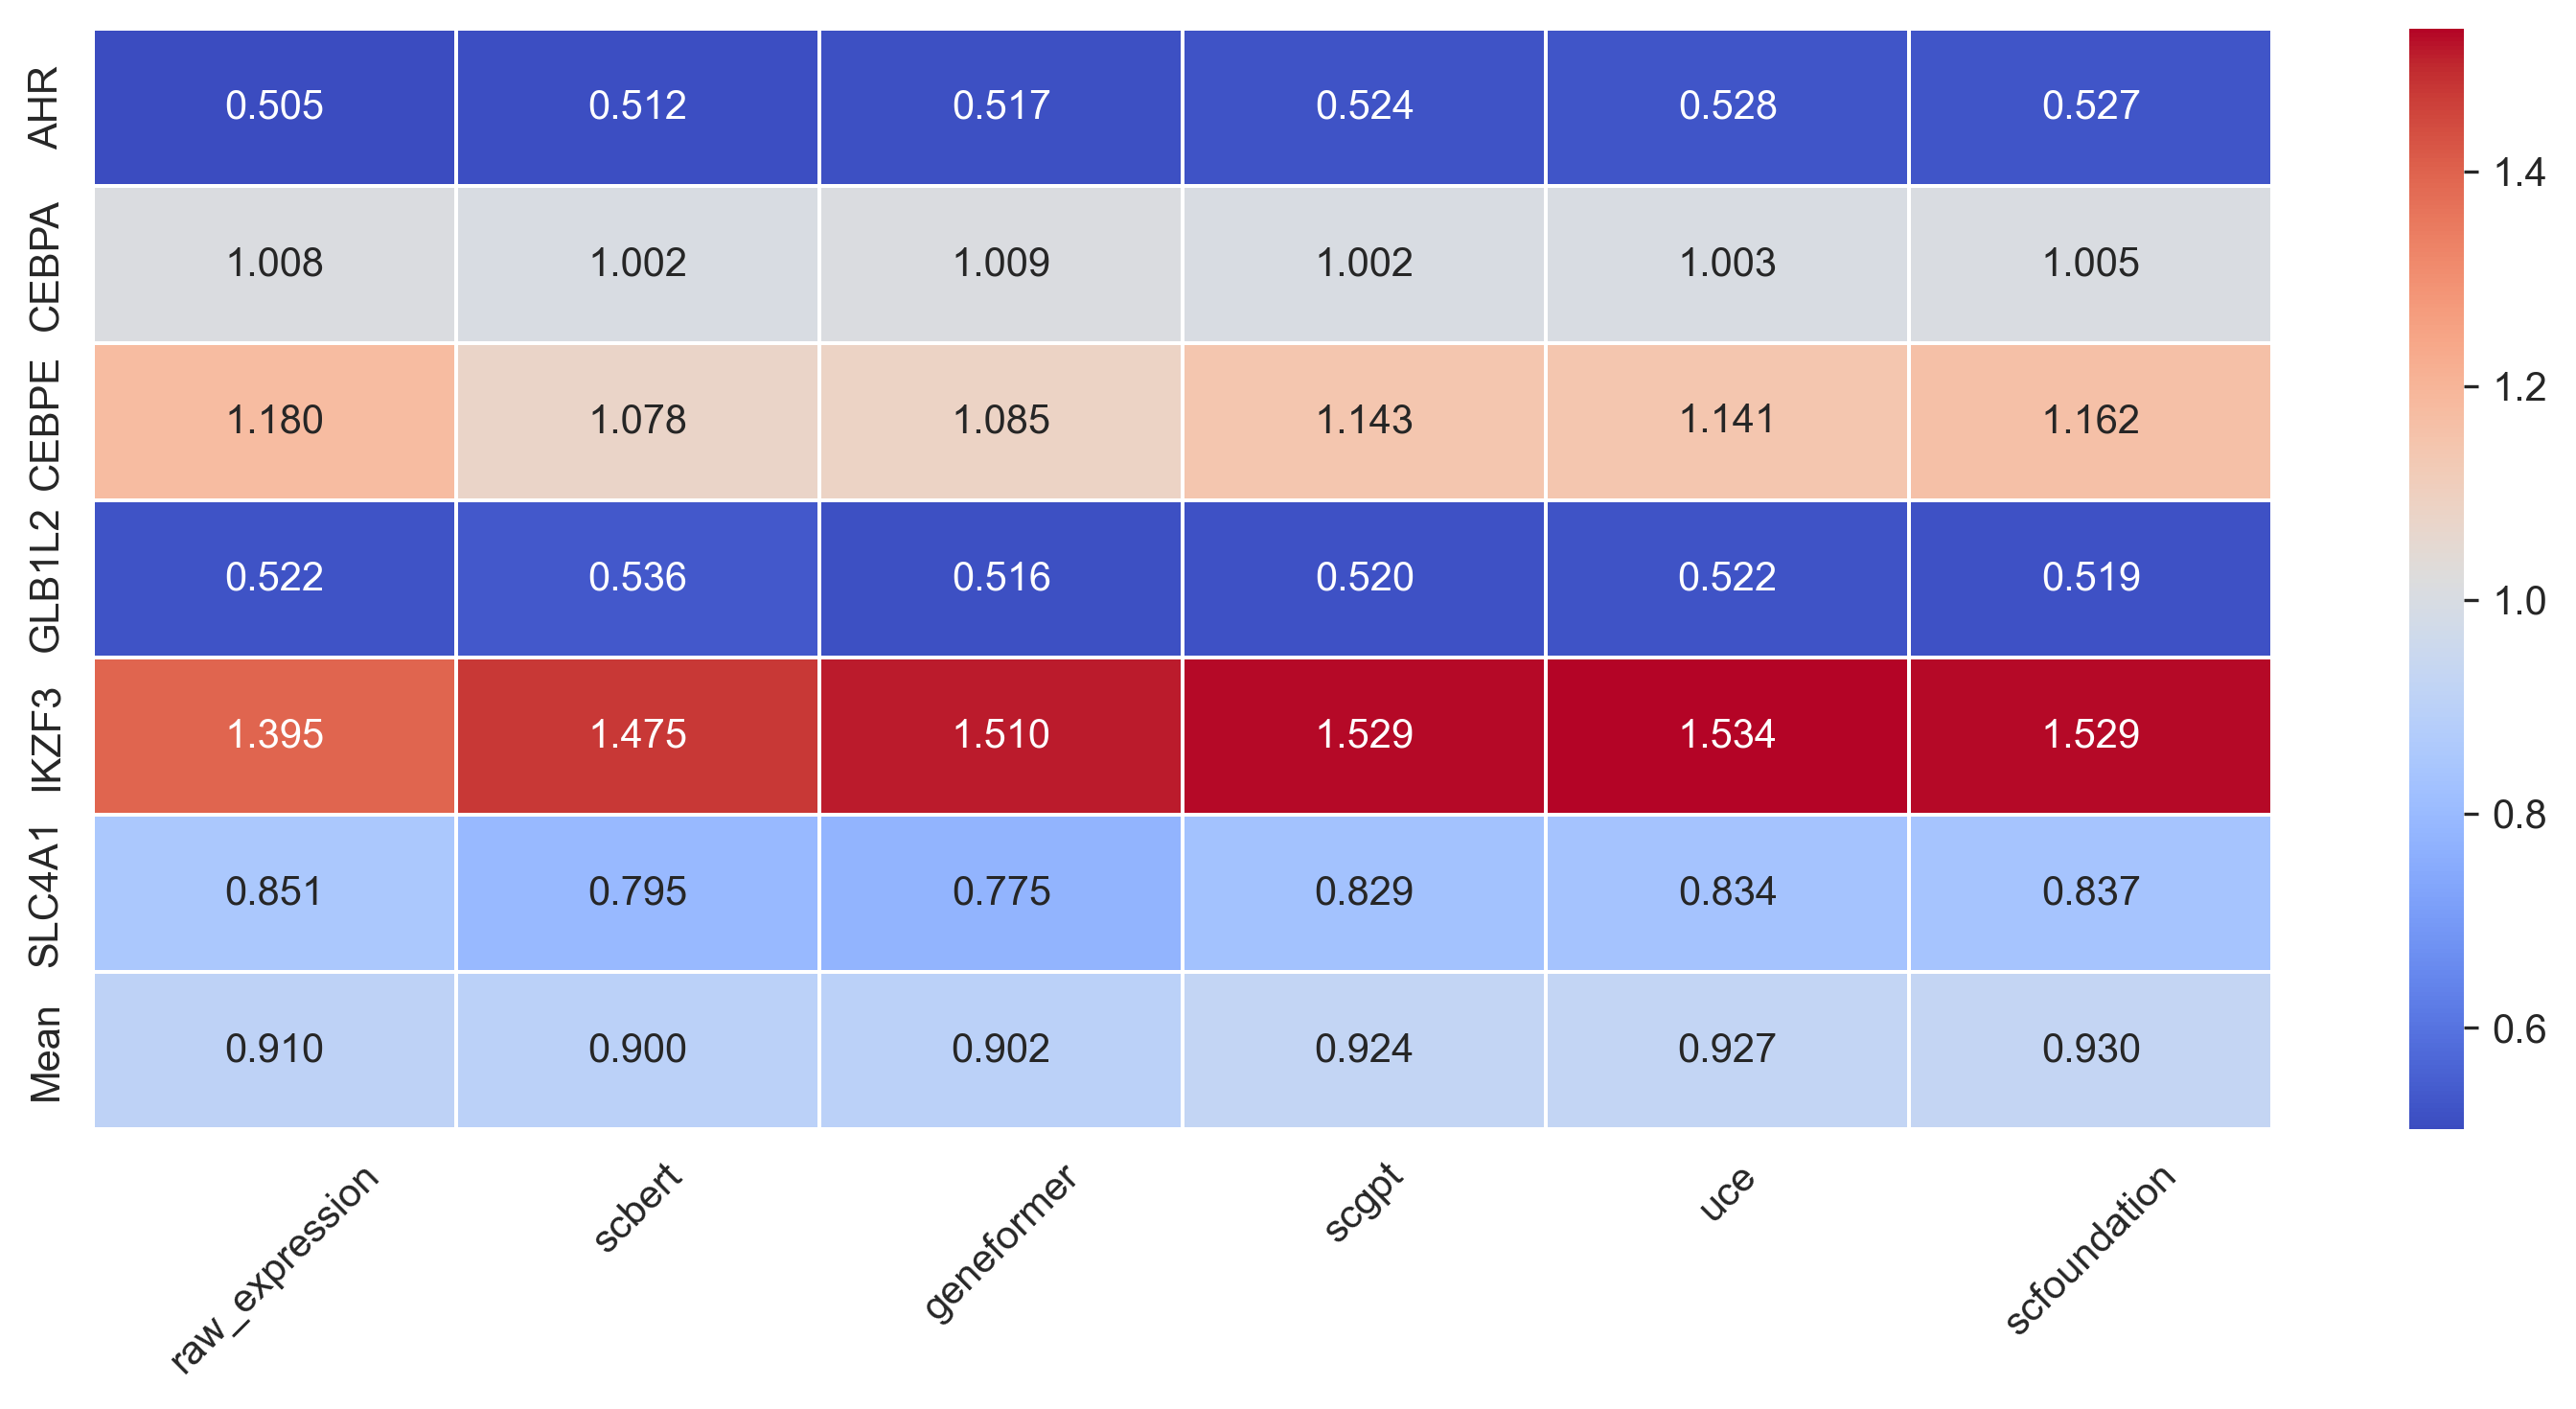

In [60]:
# Plot heatmap for pert_level_data_7
pivot_7 = pivot_7.round(3)
plt.figure(figsize=(10, 5), dpi=300)
sns.heatmap(pivot_7, annot=True, fmt=".3f", linewidths=.5, cmap="coolwarm", cbar=True)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45)
# plt.colorbar()
plt.tight_layout()
plt.savefig('individual_perturbation_results_heatmap_7_non_adj.pdf')